# Assumptions

Assumptions:



* All code was run on the A100 GPU
* All model sizes are of a gzipped tflite model in order to see the practical benefits of various optimization techniques. For example, in order to see the model size benefits of pruning both `strip_pruning` and a compression algorithm (e.g. via gzip) are necessary to apply.

  * The `strip_pruning` method removes the wrappers that are only needed during training, which would otherwise add to model size.
  * A compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is added redundancy that algorithms can utilize to further compress the model.

* For problems #2 & #4, due to the extremely long evaluation times on the training set I only evaluated 900 randomly selected images from the training set.

* For problem #6, in order to achieve a like-for-like comparison I ran the inference for all models as a TFLite model.



# Setup

In [1]:
!pip show tensorflow;

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [2]:
!pip install tensorflow_datasets

In [3]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.0 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import tempfile
import zipfile

seed = 47
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


def get_gzipped_model_size(file):
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [5]:
# List all available devices seen by TensorFlow
print("Available devices:")
print(tf.config.list_physical_devices())

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download and Prepare Data

In [6]:
download_config = tfds.download.DownloadConfig(register_checksums=True)

# Load the entire dataset
(train_ds, test_ds), info = tfds.load(
    'plant_leaves',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    try_gcs=False,
    download_and_prepare_kwargs={'download_config': download_config}
)

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/4502 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_leaves/0.1.0.incompleteWE193V/plant_leaves-train.tfrecord*...:   0%|…

Dataset plant_leaves downloaded and prepared to /root/tensorflow_datasets/plant_leaves/0.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='plant_leaves',
    full_name='plant_leaves/0.1.0',
    description="""
    This dataset consists of 4502 images of healthy and unhealthy plant leaves
    divided into 22 categories by species and state of health. The images are in
    high resolution JPG format.
    
    There are no files with label prefix 0000, therefore label encoding is shifted
    by one (e.g. file with label prefix 0001 gets encoded label 0).
    
    Note: Each image is a separate download. Some might rarely fail, therefore make
    sure to restart if that happens. An exception will be raised in case one of the
    downloads repeatedly fails.
    
    Dataset URL: https://data.mendeley.com/datasets/hb74ynkjcn/1 License:
    http://creativecommons.org/licenses/by/4.0
    """,
    homepage='https://data.mendeley.com/datasets/hb74ynkjcn/1',
    data_di

# Samples: 4502
# Training: 3602
# Training: 900
# Classes in the dataset: 22


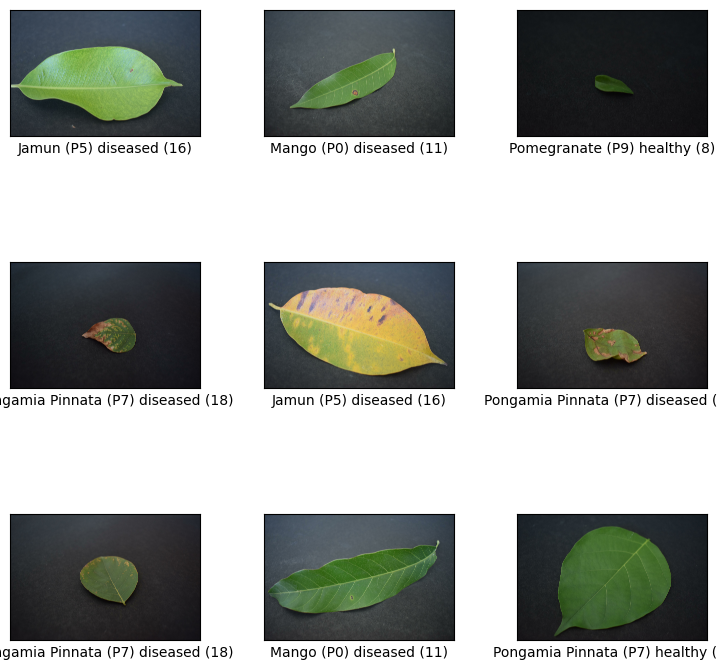

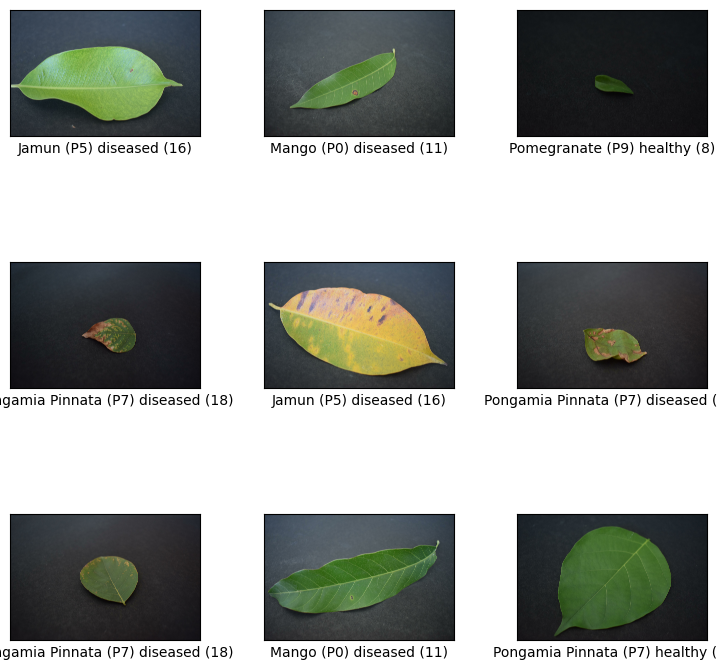

In [7]:
# Get the number of classes from the dataset info [Make sure you have 22 classes here]

print("# Samples:", info.splits['train'].num_examples)
print("# Training:", len(train_ds))
print("# Training:", len(test_ds))
print("# Classes in the dataset:", info.features['label'].num_classes)

tfds.visualization.show_examples(train_ds, info)

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Resize and rescale all images to 224x224 and normalize pixel values to be in the range of [-1, 1]
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
])

# Apply resize and rescale to both dataset splits
train_ds_aug = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds_aug = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# Cache, generate batches, and prefetch them using a suitable buffer size that does not exceed system memory
train_ds_batch = train_ds_aug.cache().batch(BATCH_SIZE).prefetch(buffer_size=10)
test_ds_batch = test_ds_aug.cache().batch(BATCH_SIZE).prefetch(buffer_size=10)

# Problem 1: Implement Base Model

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

## Design

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

M = Sequential([
  base_model,
  Flatten(),
  Dense(512, activation='relu'),
  BatchNormalization(),
  Dense(22, activation='softmax', name="output_layer"),
])

M.compile(
  optimizer=tf.keras.optimizers.Adam(0.0001),
  loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics = ["accuracy"]
)

M.summary(expand_nested=True)

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                               |
| block1_conv1 (Conv2D)      (None, 224, 224, 64)      1792     |
|                                                               |
| block1_conv2 (Conv2D)      (None, 224, 224, 64)      36928    |
|                                                               |
| block1_pool (MaxPooling2D  (None, 112, 112, 64)      0        |
| )                                                             |
|                                                               |
| block2_conv1 (Conv2D)      (None, 112, 112, 128)     

## Train

In [11]:
# Since the data was batched above using a data structure tensorflow recognizes
# the fit function figures out the steps_per_epoch for us.

history = M.fit(train_ds_batch, epochs=5, shuffle=False)

Epoch 1/5
113/113 [==============================] - 58s 436ms/step - loss: 0.8489 - accuracy: 0.7357
Epoch 2/5
113/113 [==============================] - 3s 25ms/step - loss: 0.1979 - accuracy: 0.9531
Epoch 3/5
113/113 [==============================] - 3s 24ms/step - loss: 0.0857 - accuracy: 0.9883
Epoch 4/5
113/113 [==============================] - 3s 24ms/step - loss: 0.0455 - accuracy: 0.9944
Epoch 5/5
113/113 [==============================] - 3s 24ms/step - loss: 0.0289 - accuracy: 0.9978


## Test

In [12]:
_, baseline_model_accuracy = M.evaluate(test_ds_batch, verbose=0)
print(f"Test Accuracy: {baseline_model_accuracy*100:.2f}%")

Test Accuracy: 89.67%


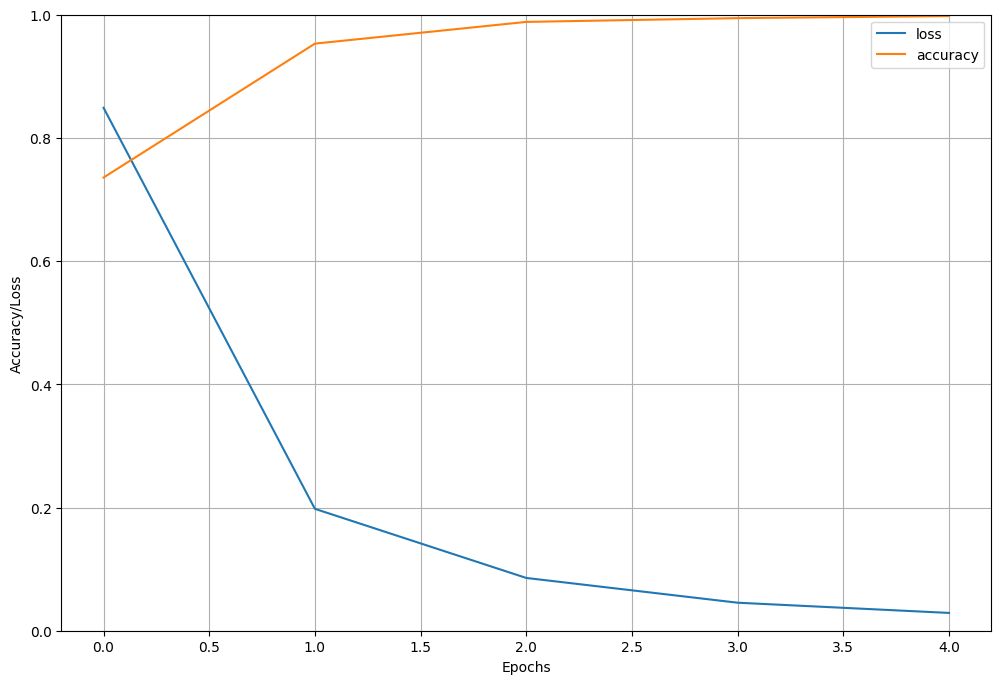

In [13]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.show()

## Model Size

In [14]:
_, baseline_model_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(M, baseline_model_keras_file, include_optimizer=False)

<ipython-input-14-d84062898a1d>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(M, baseline_model_keras_file, include_optimizer=False)


In [15]:
base_model_converter = tf.lite.TFLiteConverter.from_keras_model(M)
M_CONVERTED = base_model_converter.convert()

# Saving the model.
_, baseline_model_tflite_file = tempfile.mkstemp('.tflite')
with open(baseline_model_tflite_file, 'wb') as f:
    f.write(M_CONVERTED)

In [16]:
print(f"Size of gzipped baseline Keras model: {(get_gzipped_model_size(baseline_model_keras_file)/1024/1024):.2f} MB")
print(f"Size of gzipped baseline TFLITE model: {(get_gzipped_model_size(baseline_model_tflite_file)/1024/1024):.2f} MB")

Size of gzipped baseline Keras model: 97.52 MB
Size of gzipped baseline TFLITE model: 97.50 MB


# Problem 2: Quantization

In [17]:
quant_train_sample = train_ds_aug.shuffle(len(train_ds)).take(900)

train_images = []
train_labels = []
for image, label in quant_train_sample:
    train_images.append(image)
    train_labels.append(label)

test_images = []
test_labels = []
for image, label in test_ds_batch.take(len(test_ds_batch)).unbatch():
    test_images.append(image)
    test_labels.append(label)

#Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter, images, labels):
    prediction= []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']

    for i, image in enumerate(images):
        if i % 100 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))

        # Check if the input type is quantized, then rescale input data to uint8
        if input_format == np.uint8:
          input_scale, input_zero_point = interpreter.get_input_details()[0]['quantization']
          image = image / input_scale + input_zero_point

        image = np.expand_dims(image, axis=0).astype(input_format)


        interpreter.set_tensor(input_index, image)

        # Run inference.
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        predicted_label = np.argmax(output()[0])
        prediction.append(predicted_label)

    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy.
    prediction = np.array(prediction)
    accuracy = (prediction == labels).mean()
    return accuracy


In [18]:
print(f"# Test Images: {len(test_images)}")
print(f"# Test Labels: {len(test_labels)}")

# Test Images: 900
# Test Labels: 900


## Dynamic Range Quantization

In [19]:
drq_converter = tf.lite.TFLiteConverter.from_keras_model(M)
drq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
M_DRQ = drq_converter.convert()

# Saving the model.
_, drq_tflite_file = tempfile.mkstemp('.tflite')
with open(drq_tflite_file, 'wb') as f:
    f.write(M_DRQ)

In [20]:
drq_interpreter = tf.lite.Interpreter(drq_tflite_file)
drq_interpreter.allocate_tensors()

### Evaluate on Training

In [21]:
drq_train_accuracy = evaluate(drq_interpreter, train_images, train_labels)
print(f"Dynamic Range Quantization TFLite Model Train Accuracy: {drq_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


Dynamic Range Quantization TFLite Model Train Accuracy: 99.67%


### Evaluate on Test

In [22]:
drq_test_accuracy = evaluate(drq_interpreter, test_images, test_labels)
print(f"Dynamic Range Quantization TFLite Model Test Accuracy: {drq_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


Dynamic Range Quantization TFLite Model Test Accuracy: 89.78%


### Model Size

In [23]:
print(f"Size of gzipped M_DRQ TFlite model: {(get_gzipped_model_size(drq_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_DRQ TFlite model: 22.76 MB


## Full Integer Quantization

In [24]:
fiq_converter = tf.lite.TFLiteConverter.from_keras_model(M)

# Defining the representative dataset from training images.
def representative_data_gen():
    rep_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(1)
    for input_value in rep_ds.take(100):
        yield [input_value]

fiq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
fiq_converter.representative_dataset = representative_data_gen

fiq_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
fiq_converter.inference_input_type = tf.uint8
fiq_converter.inference_output_type = tf.uint8

M_FIQ = fiq_converter.convert()

_, fiq_tflite_file = tempfile.mkstemp('.tflite')
with open(fiq_tflite_file, 'wb') as f:
    f.write(M_FIQ)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [25]:
fiq_interpreter = tf.lite.Interpreter(fiq_tflite_file)
fiq_interpreter.allocate_tensors()

### Evaluate on Training

In [26]:
fiq_train_accuracy = evaluate(fiq_interpreter, train_images, train_labels)
print(f"Integer Quantization TFLite Model Train Accuracy: {fiq_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


Integer Quantization TFLite Model Train Accuracy: 99.67%


### Evaluate on Test

In [27]:
fiq_test_accuracy = evaluate(fiq_interpreter, test_images, test_labels)
print(f"Integer Quantization TFLite Model Test Accuracy: {fiq_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


Integer Quantization TFLite Model Test Accuracy: 89.78%


### Model Size

In [28]:
print(f"Size of gzipped M_FIQ TFlite model: {(get_gzipped_model_size(fiq_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_FIQ TFlite model: 22.77 MB


##  Float-16 Quantization

In [29]:
f16q_converter = tf.lite.TFLiteConverter.from_keras_model(M)

f16q_converter.optimizations = [tf.lite.Optimize.DEFAULT]
f16q_converter.target_spec.supported_types = [tf.float16]

M_F16Q = f16q_converter.convert()

# Saving the model.
_, f16q_tflite_file = tempfile.mkstemp('.tflite')
with open(f16q_tflite_file, 'wb') as f:
    f.write(M_F16Q)

In [30]:
f16q_interpreter = tf.lite.Interpreter(f16q_tflite_file)
f16q_interpreter.allocate_tensors()

### Evaluate on Training

In [31]:
f16q_train_accuracy = evaluate(f16q_interpreter, train_images, train_labels)
print(f"Float 16 Quantized TFLite Model Train Accuracy: {f16q_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


Float 16 Quantized TFLite Model Train Accuracy: 99.78%


### Evaluate on Test

In [32]:
f16q_test_accuracy = evaluate(f16q_interpreter, test_images, test_labels)
print(f"Float 16 Quantized TFLite Model Test Accuracy: {f16q_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


Float 16 Quantized TFLite Model Test Accuracy: 89.67%


### Model Size

In [33]:
print(f"Size of gzipped M_FIQ TFlite model: {(get_gzipped_model_size(f16q_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_FIQ TFlite model: 48.12 MB


# Problem 3: Pruning

In [34]:
import tensorflow_model_optimization as tfmot

pruning_schedule_one = tfmot.sparsity.keras.PolynomialDecay(
           initial_sparsity=0,
           final_sparsity=0.5,
           begin_step=0,
           end_step=len(train_ds_batch) * 5)

pruning_schedule_two = tfmot.sparsity.keras.PolynomialDecay(
           initial_sparsity=0.5,
           final_sparsity=0.75,
           begin_step=0,
           end_step=len(train_ds_batch) * 5)

class PrunePlantLeavesModelPolicy(tfmot.sparsity.keras.PruningPolicy):
  def allow_pruning(self, layer):
    return isinstance(layer, tf.keras.layers.Conv2D) and ("block3" in layer.name or "block4" in layer.name or "block5" in layer.name)

  def ensure_model_supports_pruning(self, model):
    return True

def create_clone_function(schedule):
    def apply_pruning_to_dense(layer):
        if isinstance(layer, tf.keras.layers.Dense) and layer.name != "output_layer":
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **schedule)
        elif isinstance(layer, tf.keras.models.Model) and layer.name == "vgg16":
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **schedule)

        return layer

    return apply_pruning_to_dense


In [35]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

## First Schedule

In [36]:
M_P1 = tf.keras.models.clone_model(
    M,
    clone_function=create_clone_function({
        'pruning_schedule': pruning_schedule_one,
        'pruning_policy': PrunePlantLeavesModelPolicy()
    }),
)

M_P1.compile(
  optimizer='adam',
  loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics = ["accuracy"]
)

M_P1.summary(expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         29165394  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                               |
| block1_conv1 (Conv2D)      (None, 224, 224, 64)      1792     |
|                                                               |
| block1_conv2 (Conv2D)      (None, 224, 224, 64)      36928    |
|                                                               |
| block1_pool (MaxPooling2D  (None, 112, 112, 64)      0        |
| )                                                             |
|                                                               |
| block2_conv1 (Conv2D)      (None, 112, 112, 128)     73856    |
|                                                     

In [37]:
M_P1.fit(train_ds_batch, epochs=5, shuffle=False, callbacks=callbacks)

Epoch 1/5
113/113 [==============================] - 13s 60ms/step - loss: 0.5382 - accuracy: 0.8423
Epoch 2/5
113/113 [==============================] - 3s 28ms/step - loss: 0.1029 - accuracy: 0.9747
Epoch 3/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0479 - accuracy: 0.9889
Epoch 4/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0268 - accuracy: 0.9953
Epoch 5/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0213 - accuracy: 0.9953


In [38]:
M_P1_FINAL = tfmot.sparsity.keras.strip_pruning(M_P1)

M_P1_FINAL.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

M_P1_FINAL.summary(expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                               |
| block1_conv1 (Conv2D)      (None, 224, 224, 64)      1792     |
|                                                               |
| block1_conv2 (Conv2D)      (None, 224, 224, 64)      36928    |
|                                                               |
| block1_pool (MaxPooling2D  (None, 112, 112, 64)      0        |
| )                                                             |
|                                                               |
| block2_conv1 (Conv2D)      (None, 112, 112, 128)     73856    |
|                                                     

### Evaluate on Train

In [39]:
_, m_p1_train_accuracy = M_P1_FINAL.evaluate(train_ds_batch, verbose=0)
print(f"Pruned Schedule 1 Train Accuracy: {m_p1_train_accuracy*100:.2f}%")

Pruned Schedule 1 Train Accuracy: 99.72%


### Evaluate on Test


In [40]:
_, m_p1_test_accuracy = M_P1_FINAL.evaluate(test_ds_batch, verbose=0)
print(f"Pruned Schedule 1 Test Accuracy: {m_p1_test_accuracy*100:.2f}%")

Pruned Schedule 1 Test Accuracy: 91.22%


### Model Size

In order to see the model size benefits of pruning both `strip_pruning` and a standard compression algorithm (e.g. via gzip) are necessary to apply. The `strip_pruning` function was applied above and so here we apply gzip.

In [41]:
_, m1_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(M_P1_FINAL, m1_pruned_keras_file, include_optimizer=False)

<ipython-input-41-0dcc7b025c32>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(M_P1_FINAL, m1_pruned_keras_file, include_optimizer=False)


In [42]:
m1_pruned_converter = tf.lite.TFLiteConverter.from_keras_model(M_P1_FINAL)
m1_pruned_tflite_model = m1_pruned_converter.convert()


_, m_p1_pruned_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p1_pruned_tflite_file, 'wb') as f:
  f.write(m1_pruned_tflite_model)

In [43]:
print(f"Size of gzipped baseline Keras model: {(get_gzipped_model_size(baseline_model_keras_file)/1024/1024):.2f} MB")
print(f"Size of gzipped pruned Keras model: {(get_gzipped_model_size(m1_pruned_keras_file)/1024/1024):.2f} MB")
print(f"Size of gzipped pruned TFlite model: {(get_gzipped_model_size(m_p1_pruned_tflite_file)/1024/1024):.2f} MB")

Size of gzipped baseline Keras model: 97.52 MB
Size of gzipped pruned Keras model: 59.95 MB
Size of gzipped pruned TFlite model: 59.75 MB


## Second Schedule

In [44]:
M_P2 = tf.keras.models.clone_model(
    M,
    clone_function=create_clone_function({
        'pruning_schedule': pruning_schedule_two,
        'pruning_policy': PrunePlantLeavesModelPolicy()\
    }),
)

M_P2.compile(
  optimizer='adam',
  loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics = ["accuracy"]
)

M_P2.summary(expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         29165394  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                               |
| block1_conv1 (Conv2D)      (None, 224, 224, 64)      1792     |
|                                                               |
| block1_conv2 (Conv2D)      (None, 224, 224, 64)      36928    |
|                                                               |
| block1_pool (MaxPooling2D  (None, 112, 112, 64)      0        |
| )                                                             |
|                                                               |
| block2_conv1 (Conv2D)      (None, 112, 112, 128)     73856    |
|                                                     

In [45]:
M_P2.fit(train_ds_batch, epochs=5, shuffle=False, callbacks=callbacks)

Epoch 1/5
113/113 [==============================] - 8s 27ms/step - loss: 0.1184 - accuracy: 0.9703
Epoch 2/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0816 - accuracy: 0.9781
Epoch 3/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0987 - accuracy: 0.9692
Epoch 4/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0939 - accuracy: 0.9720
Epoch 5/5
113/113 [==============================] - 3s 27ms/step - loss: 0.0518 - accuracy: 0.9839


In [46]:
M_P2_FINAL = tfmot.sparsity.keras.strip_pruning(M_P2)

M_P2_FINAL.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

M_P2_FINAL.summary(expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                               |
| block1_conv1 (Conv2D)      (None, 224, 224, 64)      1792     |
|                                                               |
| block1_conv2 (Conv2D)      (None, 224, 224, 64)      36928    |
|                                                               |
| block1_pool (MaxPooling2D  (None, 112, 112, 64)      0        |
| )                                                             |
|                                                               |
| block2_conv1 (Conv2D)      (None, 112, 112, 128)     73856    |
|                                                     

### Evaluate on Training

In [47]:
_, m_p2_train_accuracy = M_P2_FINAL.evaluate(train_ds_batch, verbose=0)
print(f"Pruned Schedule 2 Train Accuracy: {m_p2_train_accuracy*100:.2f}%")

Pruned Schedule 2 Train Accuracy: 97.17%


### Evaluate on Test

In [48]:
_, m_p2_test_accuracy = M_P2_FINAL.evaluate(test_ds_batch, verbose=0)
print(f"Pruned Schedule 2 Test Accuracy: {m_p2_test_accuracy*100:.2f}%")

Pruned Schedule 2 Test Accuracy: 88.33%


### Model Size

In order to see the model size benefits of pruning both `strip_pruning` and a standard compression algorithm (e.g. via gzip) are necessary to apply. The `strip_pruning` function was applied above and so here we apply gzip.

In [49]:
_, m2_pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(M_P2_FINAL, m2_pruned_keras_file, include_optimizer=False)

<ipython-input-49-019af4bb1a4d>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(M_P2_FINAL, m2_pruned_keras_file, include_optimizer=False)


In [50]:
m2_pruned_converter = tf.lite.TFLiteConverter.from_keras_model(M_P2_FINAL)
m2_pruned_tflite_model = m2_pruned_converter.convert()

_, m_p2_pruned_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p2_pruned_tflite_file, 'wb') as f:
  f.write(m2_pruned_tflite_model)

In [51]:
print(f"Size of gzipped baseline Keras model: {(get_gzipped_model_size(baseline_model_keras_file)/1024/1024):.2f} MB")
print(f"Size of gzipped pruned Keras model: {(get_gzipped_model_size(m2_pruned_keras_file)/1024/1024):.2f} MB")
print(f"Size of gzipped pruned TFlite model: {(get_gzipped_model_size(m_p2_pruned_tflite_file)/1024/1024):.2f} MB")

Size of gzipped baseline Keras model: 97.52 MB
Size of gzipped pruned Keras model: 36.74 MB
Size of gzipped pruned TFlite model: 36.40 MB


## Discussion

They are certainly considerations for pruning a neural network differently depending on whether the value of the initial sparsity is 0 or 0.5. Below we discuss the benefits and drawbacks for each value.

Case initital_sparsity = 0

* Benefit: Early layers often capture general features of the dataset and so if significant weights happen to be set to zero this can affect model accuracy. Thus you can prune layers with slightly few parameters or layers earlier in the network.
* Drawback: One may need to more thoroughly search through the model to find which and under what characteristics to prune a layer. You can see my effort in doing this in my custom pruning policy. I created this to try and balance accuracy with the model size.

Case initital_sparsity = 0.5

* Benefit: One may not need to search through the model as carefully to find which layers to prune. One may be able to focus mostly on the layers with the most parameters like the first dense layer in my model for the homework. That first dense layer contained over 60% of the total parameters.
* Benefit: A bunch of zeros is more memory efficient, but this shouldn’t come at the cost of excessive accuracy degradation.
* Drawback: Early layers often capture general features of the dataset and so if significant weights happen to be set to zero this can affect model accuracy. Thus one wouldn’t want to prune earlier layers or layers with too few parameters.


# Problem 4: Quantization of Pruned Models

## M_P1 With Dynamic Range Quantization

In [95]:
m_p1_drq_converter = tf.lite.TFLiteConverter.from_keras_model(M_P1_FINAL)

m_p1_drq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
M_P1_DRQ = m_p1_drq_converter.convert()

# Saving the model.
_, m_p1_drq_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p1_drq_tflite_file, 'wb') as f:
    f.write(M_P1_DRQ)

In [96]:
m_p1_drq_interpreter = tf.lite.Interpreter(m_p1_drq_tflite_file)
m_p1_drq_interpreter.allocate_tensors()

### Evaluate on Training

In [97]:
m_p1_drq_train_accuracy = evaluate(m_p1_drq_interpreter, train_images, train_labels)
print(f"M_P1_DRQ TFLite Model Train Accuracy: {m_p1_drq_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P1_DRQ TFLite Model Train Accuracy: 97.44%


### Evaluate on Test

In [98]:
m_p1_drq_test_accuracy = evaluate(m_p1_drq_interpreter, test_images, test_labels)
print(f"M_P1_DRQ TFLite Model Test Accuracy: {m_p1_drq_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P1_DRQ TFLite Model Test Accuracy: 88.11%


### Model Size

In [99]:
print(f"Size of gzipped M_P1_DRQ TFlite model: {(get_gzipped_model_size(m_p1_drq_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P1_DRQ TFlite model: 9.58 MB


In [104]:
print(f"Size of gzipped M_P1_DRQ TFlite model w/ Exponential Sparsity: {(get_gzipped_model_size(m_p1_drq_es_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P1_DRQ TFlite model w/ Exponential Sparsity: 13.49 MB


## M_P1 With Full Integer Quantization

In [57]:
# Passing the baseline Keras model to the TF Lite Converter.
m_p1_fiq_converter = tf.lite.TFLiteConverter.from_keras_model(M_P1_FINAL)

# Defining the representative dataset from training images.
def representative_data_gen():
    rep_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(1)
    for input_value in rep_ds.take(100):
        yield [input_value]

m_p1_fiq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
m_p1_fiq_converter.representative_dataset = representative_data_gen

m_p1_fiq_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]

# Setting the input and output tensors to uint8.
m_p1_fiq_converter.inference_input_type = tf.uint8
m_p1_fiq_converter.inference_output_type = tf.uint8

# Converting the model.
M_P1_FIQ = m_p1_fiq_converter.convert()

# Saving the Integer Quantized TF Lite model.
_, m_p1_int_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p1_int_tflite_file, 'wb') as f:
    f.write(M_P1_FIQ)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [58]:
m_p1_fiq_interpreter = tf.lite.Interpreter(m_p1_int_tflite_file)
m_p1_fiq_interpreter.allocate_tensors()

### Evaluate on Training

In [59]:
m_p1_fiq_train_accuracy = evaluate(m_p1_fiq_interpreter, train_images, train_labels)
print(f"M_P1_FIQ TFLite Model Train Accuracy: {m_p1_fiq_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P1_FIQ TFLite Model Train Accuracy: 97.33%


### Evaluate on Test

In [60]:
m_p1_fiq_test_accuracy = evaluate(m_p1_fiq_interpreter, test_images, test_labels)
print(f"M_P1_FIQ TFLite Model Test Accuracy: {m_p1_fiq_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P1_FIQ TFLite Model Test Accuracy: 88.22%


### Model Size

In [61]:
print(f"Size of gzipped M_P1_FIQ TFlite model: {(get_gzipped_model_size(m_p1_int_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P1_FIQ TFlite model: 9.59 MB


## M_P1 with Float-16 Quantization


In [62]:
m_p1_f16q_converter = tf.lite.TFLiteConverter.from_keras_model(M_P1_FINAL)

m_p1_f16q_converter.optimizations = [tf.lite.Optimize.DEFAULT]
m_p1_f16q_converter.target_spec.supported_types = [tf.float16]

M_P1_F16Q = m_p1_f16q_converter.convert()

# Saving the model.
_, m_p1_f16q_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p1_f16q_tflite_file, 'wb') as f:
    f.write(M_P1_F16Q)

In [63]:
m_p1_f16q_interpreter = tf.lite.Interpreter(m_p1_f16q_tflite_file)
m_p1_f16q_interpreter.allocate_tensors()

#### Evaluate on Training

In [64]:
m_p1_f16q_train_accuracy = evaluate(m_p1_f16q_interpreter, train_images, train_labels)
print(f"M_P1_F16Q TFLite Model Train Accuracy: {m_p1_f16q_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P1_F16Q TFLite Model Train Accuracy: 97.56%


#### Evaluate on Test

In [65]:
m_p1_f16q_test_accuracy = evaluate(m_p1_f16q_interpreter, test_images, test_labels)
print(f"M_P1_F16Q TFLite Model Test Accuracy: {m_p1_f16q_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P1_F16Q TFLite Model Test Accuracy: 88.33%


### Model Size

In [66]:
print(f"Size of gzipped M_P1_F16Q TFlite model: {(get_gzipped_model_size(m_p1_f16q_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P1_F16Q TFlite model: 21.36 MB


## M_P2 With Dynamic Range Quantization

In [67]:
m_p2_drq_converter = tf.lite.TFLiteConverter.from_keras_model(M_P2_FINAL)

m_p2_drq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
M_P2_DRQ = drq_converter.convert()

# Saving the model.
_, m_p2_drq_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p2_drq_tflite_file, 'wb') as f:
    f.write(M_P2_DRQ)

In [68]:
m_p2_drq_interpreter = tf.lite.Interpreter(m_p2_drq_tflite_file)
m_p2_drq_interpreter.allocate_tensors()

#### Evaluate on Training

In [69]:
m_p2_drq_train_accuracy = evaluate(m_p2_drq_interpreter, train_images, train_labels)
print(f"M_P2_DRQ TFLite Model Train Accuracy:{m_p2_drq_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P2_DRQ TFLite Model Train Accuracy:97.44%


#### Evaluate on Test

In [70]:
m_p2_drq_test_accuracy = evaluate(m_p2_drq_interpreter, test_images, test_labels)
print(f"M_P2_DRQ TFLite Model Test Accuracy: {m_p2_drq_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P2_DRQ TFLite Model Test Accuracy: 88.11%


### Model Size

In [71]:
print(f"Size of gzipped M_P2_DRQ TFlite model: {(get_gzipped_model_size(m_p2_drq_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P2_DRQ TFlite model: 9.58 MB


## M_P2 With Full Integer Quantization

In [72]:
# Passing the baseline Keras model to the TF Lite Converter.
m_p2_fiq_converter = tf.lite.TFLiteConverter.from_keras_model(M_P2_FINAL)

# Defining the representative dataset from training images.
def representative_data_gen():
    rep_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(1)
    for input_value in rep_ds.take(100):
        yield [input_value]

m_p2_fiq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
m_p2_fiq_converter.representative_dataset = representative_data_gen

m_p2_fiq_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]

# Setting the input and output tensors to uint8.
m_p2_fiq_converter.inference_input_type = tf.uint8
m_p2_fiq_converter.inference_output_type = tf.uint8

M_P2_FIQ = m_p2_fiq_converter.convert()

# Saving the Integer Quantized TF Lite model.
_, m_p2_fiq_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p2_fiq_tflite_file, 'wb') as f:
    f.write(M_P2_FIQ)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [73]:
m_p2_fiq_interpreter = tf.lite.Interpreter(m_p2_fiq_tflite_file)
m_p2_fiq_interpreter.allocate_tensors()

### Evaluate on Training

In [74]:
m_p2_fiq_train_accuracy = evaluate(m_p2_fiq_interpreter, train_images, train_labels)
print(f"M_P2_FIQ TFLite Model Train Accuracy: {m_p2_fiq_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P2_FIQ TFLite Model Train Accuracy: 97.33%


### Evaluate on Test



In [75]:
m_p2_fiq_test_accuracy = evaluate(m_p2_fiq_interpreter, test_images, test_labels)
print(f"M_P2_FIQ TFLite Model Test Accuracy: {m_p2_fiq_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P2_FIQ TFLite Model Test Accuracy: 88.22%


### Model Size

In [76]:
print(f"Size of gzipped M_P2_FIQ TFlite model: {(get_gzipped_model_size(m_p2_fiq_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P2_FIQ TFlite model: 9.59 MB


## M_P2 with Float-16 Quantization


In [77]:
m_p2_f16q_converter = tf.lite.TFLiteConverter.from_keras_model(M_P2_FINAL)

m_p2_f16q_converter.optimizations = [tf.lite.Optimize.DEFAULT]
m_p2_f16q_converter.target_spec.supported_types = [tf.float16]

M_P2_F16Q = m_p2_f16q_converter.convert()

# Saving the model.
_, m_p2_f16q_tflite_file = tempfile.mkstemp('.tflite')
with open(m_p2_f16q_tflite_file, 'wb') as f:
    f.write(M_P2_F16Q)

In [78]:
m_p2_f16q_interpreter = tf.lite.Interpreter(m_p2_f16q_tflite_file)
m_p2_f16q_interpreter.allocate_tensors()

### Evaluate on Training

In [79]:
m_p2_f16q_train_accuracy = evaluate(m_p2_f16q_interpreter, train_images, train_labels)
print(f"M_P2_F16Q TFLite Model Train Accuracy: {m_p2_f16q_train_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P2_F16Q TFLite Model Train Accuracy: 97.56%


### Evaluate on Test

In [80]:
m_p2_f16q_test_accuracy = evaluate(m_p2_f16q_interpreter, test_images, test_labels)
print(f"M_P2_F16Q TFLite Model Test Accuracy: {m_p2_f16q_test_accuracy*100:.2f}%")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.


M_P2_F16Q TFLite Model Test Accuracy: 88.33%


### Model Size

In [81]:
print(f"Size of gzipped M_P2_FIQ TFlite model: {(get_gzipped_model_size(m_p2_f16q_tflite_file)/1024/1024):.2f} MB")

Size of gzipped M_P2_FIQ TFlite model: 21.36 MB


# Problem 5: Latency Evaluation

In [82]:
import time

latency_sample = train_ds_aug.shuffle(len(train_ds_aug)).take(100)
latency_images = []
for image, _ in latency_sample:
    latency_images.append(image)

def measure_latency(interpreter, images):
    timings = np.zeros(len(images), dtype=int)
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']

    for i, image in enumerate(images):
        # Check if the input type is quantized, then rescale input data to uint8
        if input_format == np.uint8:
          input_scale, input_zero_point = interpreter.get_input_details()[0]['quantization']
          image = image / input_scale + input_zero_point

        image = np.expand_dims(image, axis=0).astype(input_format)

        interpreter.set_tensor(input_index, image)
        start_time = time.time() * 1000
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        end_time = time.time() * 1000

        timings[i] = end_time-start_time

    print(f"Average: {np.mean(timings):.2f} ms")
    print(f"Standard Deviation: {np.std(timings):.2f} ms")

#### For Model M

In [83]:
m_baseline_interpreter = tf.lite.Interpreter(baseline_model_tflite_file)
m_baseline_interpreter.allocate_tensors()

measure_latency(m_baseline_interpreter, latency_images)

Average: 517.33 ms
Standard Deviation: 4.12 ms


#### For Model M_DRQ

In [84]:
measure_latency(drq_interpreter, latency_images)

Average: 380.88 ms
Standard Deviation: 1.84 ms


#### For Model M_FIQ

In [85]:
measure_latency(fiq_interpreter, latency_images)

Average: 378.78 ms
Standard Deviation: 3.71 ms


#### For Model M_F16Q

In [86]:
measure_latency(f16q_interpreter, latency_images)

Average: 513.82 ms
Standard Deviation: 3.99 ms


#### For Model M_P1

In [87]:
m_p1_interpreter = tf.lite.Interpreter(m_p1_pruned_tflite_file)
m_p1_interpreter.allocate_tensors()

measure_latency(m_p1_interpreter, latency_images)

Average: 511.90 ms
Standard Deviation: 3.86 ms


#### For Model M_P2

In [88]:
m_p2_interpreter = tf.lite.Interpreter(m_p2_pruned_tflite_file)
m_p2_interpreter.allocate_tensors()

measure_latency(m_p2_interpreter, latency_images)

Average: 511.98 ms
Standard Deviation: 5.67 ms


#### For Model M_P1_DRQ

In [89]:
measure_latency(m_p1_drq_interpreter, latency_images)

Average: 382.79 ms
Standard Deviation: 2.42 ms


#### For Model M_P1_FIQ

In [90]:
measure_latency(m_p1_fiq_interpreter, latency_images)

Average: 379.02 ms
Standard Deviation: 3.78 ms


#### For Model M_P1_F16Q

In [91]:
measure_latency(m_p1_f16q_interpreter, latency_images)

Average: 506.01 ms
Standard Deviation: 3.58 ms


#### For Model M_P2_DRQ

In [92]:
measure_latency(m_p2_drq_interpreter, latency_images)

Average: 383.16 ms
Standard Deviation: 1.62 ms


#### For Model M_P2_FIQ

In [93]:
measure_latency(m_p2_fiq_interpreter, latency_images)

Average: 380.10 ms
Standard Deviation: 4.77 ms


#### For Model M_P2_F16Q

In [94]:
measure_latency(m_p2_f16q_interpreter, latency_images)

Average: 506.40 ms
Standard Deviation: 3.05 ms


# Problem 6: Result Analysis

Cascading compression techniques offer significant advantages over a single technique by reduced model size with minimal loss of accuracy. In all cases cascading reduced model size 3-6x when compared to just the pruned models and from 2-5 times when compared to the quantized model depending on the technique used. In addition there was only ~2% decrease in training and 1% decrease in test accuracies. That reduction is beneficial to resource constrained environments these models are deployed in. Lastly the cascaded models that used DRQ and FIQ benefitted from the increased inference time those techniques provided in the single technique case. On the other hand the test accuracy of the M_P1 model increased by ~1.5% while seeing a reduction in model size from the base model by ~50%. However the size of the model is still about ~48MB, which may be too large for some environments. That said, cascading techniques can offer improvements in size and speed for resource constrained environments over a single technique.